## Creating DataLoader

In [1]:
from cloud_dataset import CloudDataset
from pathlib import Path
from torchvision import transforms

path = Path('archive/38-Cloud_training')

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = CloudDataset(path/'train_red',
                       path/'train_green',
                       path/'train_blue',
                       path/'train_nir',
                       path/'train_gt',
                       transform)

print(f'Dataset size: {len(dataset)}')

Dataset size: 8400


In [2]:
import random

idx = random.randint(0, len(dataset) - 1)
x, y = dataset[idx]
print(f'Each sample shape: {x.shape}, {y.shape}')

Each sample shape: torch.Size([4, 128, 128]), torch.Size([128, 128])


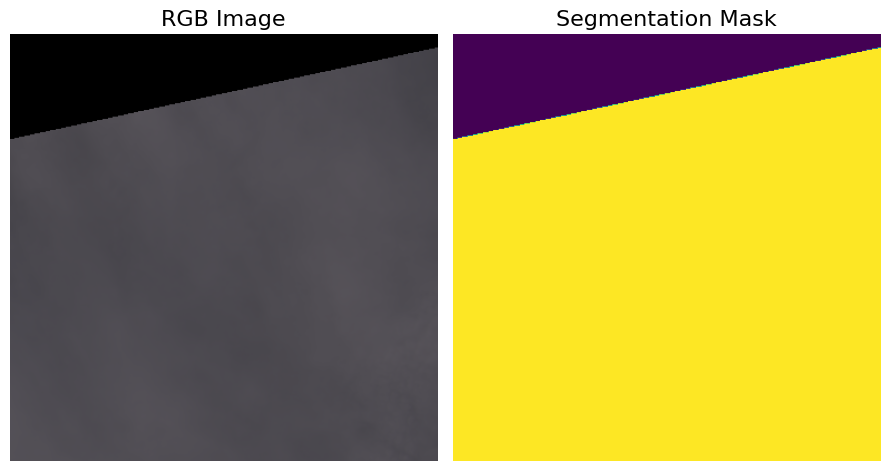

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

ax[0].imshow(dataset.open_as_nparray(idx, invert=False, include_nir=False))
ax[0].set_title('RGB Image', fontsize=16)
ax[0].axis('off')

mask = dataset.open_mask(idx)
ax[1].imshow(mask)
ax[1].set_title('Segmentation Mask', fontsize=16)
ax[1].axis('off')

plt.tight_layout()

## DataLoader class: training and validation subsets

In [4]:
from torch.utils.data import random_split, DataLoader

train_ds, valid_ds = random_split(dataset, [0.8, 0.2])

batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [5]:
xb, yb = next(iter(train_dl))
print(f'First batch shape: {xb.shape}, {yb.shape}')
# BatchSize x C x H x W

First batch shape: torch.Size([16, 4, 128, 128]), torch.Size([16, 128, 128])


## Creating the model

![model_graph](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-019-53797-9/MediaObjects/41598_2019_53797_Fig1_HTML.png?as=webp)
Source: [Convolutional Neural Networks enable efficient, accurate and fine-grained segmentation of plant species and communities from high-resolution UAV imagery](https://www.nature.com/articles/s41598-019-53797-9) paper

In [6]:
from unet_model import UNet

unet = UNet(in_channels=4, out_channels=1)

### Experimenting

In [7]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([16, 4, 128, 128]), torch.Size([16, 128, 128]))

In [8]:
block1 = unet.contract_block(4, 32, 3, 1)
c1 = block1(xb)
c1.shape

torch.Size([16, 32, 64, 64])

In [9]:
block2 = unet.expand_block(32, 3, 3, 1)
c2 = block2(c1)
c2.shape

torch.Size([16, 3, 128, 128])

In [10]:
pred = unet(xb)
pred.shape

torch.Size([16, 1, 128, 128])

## Training the model

In [11]:
import torch
from train.train import train

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# binary cross entropy, with raw logits as the unet does not have a sigmoid final layer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.00001)
epochs = 50

In [12]:
hists = train(unet, train_dl, valid_dl, loss_fn, optimizer, epochs, device)

--------------------------------------------------
Epoch 1, time elapsed: 0.98 min
Training accuracy: 0.6899, Training loss: 0.5340
Validation accuracy: 0.1739, Validation loss: 0.1330
--------------------------------------------------
Epoch 2, time elapsed: 1.99 min
Training accuracy: 0.6965, Training loss: 0.5310
Validation accuracy: 0.1742, Validation loss: 0.1325
--------------------------------------------------
Epoch 3, time elapsed: 3.01 min
Training accuracy: 0.6971, Training loss: 0.5290
Validation accuracy: 0.1742, Validation loss: 0.1320
--------------------------------------------------
Epoch 4, time elapsed: 4.06 min
Training accuracy: 0.6973, Training loss: 0.5271
Validation accuracy: 0.1742, Validation loss: 0.1316
--------------------------------------------------
Epoch 5, time elapsed: 5.10 min
Training accuracy: 0.6973, Training loss: 0.5254
Validation accuracy: 0.1742, Validation loss: 0.1311
--------------------------------------------------
Epoch 6, time elapsed: 6

KeyboardInterrupt: 

In [ ]:
# save the trained model's state dictionary
torch.save(unet.state_dict(), 'unet_model.pth')